In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams, plot, scatter

In [2]:
import os
import numpy as np
import pandas as pd
import glob as glob
import bs4 as bs
import json
import re

import pubchempy as pc

from collections import Hashable
from hashlib import md5

import tqdm


In [3]:
import cachegrab as cg
from cachegrab.cachers.basic import BasicCachingGetter as BCG

In [4]:
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [5]:
basedir = '/home/mike/data/chemistry/compatibility/parsed/'
files = glob.glob(basedir + '*.csv')
files

['/home/mike/data/chemistry/compatibility/parsed/tabula-Chemical-Resistance-Chart.csv',
 '/home/mike/data/chemistry/compatibility/parsed/ColeParmerRaw02.csv',
 '/home/mike/data/chemistry/compatibility/parsed/Graco_ChemCompGuidecsv.csv']

In [6]:
frames = [pd.read_csv(fn) for fn in files]

In [7]:
frames[0].head()

,chemical,302 Stainless Steel,304 Stainless Steel,316 Stainless Steel,440 Stainless Steel,Aluminum,Titanium,Hastelloy C,Cast Bronze,Brass,...,Carbon,Ceramic,Ceramagnet A,Viton,Buna-N (Nitrile),Silicon,Neoprene,EPDM,Natural rubber,Epoxy
0,Acetaldehyde 5,A,A,A,-,B,A,A,D,-,...,A,A,-,D,B,B,D,B,C,A
1,Acetamide,-,B,A,-,-,-,-,-,-,...,-,A,-,A,A,-,A,A,D,A
2,Acetate Solv. 2,A,B,A,B,B,-,-,A,C,...,A,A,-,D,D,-,D,-,-,A
3,"Acetic Acid, Glacia 1",-,B,A,A,B,A,A,C,C,...,A,A,-,D,D,B,C,B,C,B
4,Acetic Acid 20%,-,B,A,-,-,A,A,-,C,...,-,A,-,A,C,-,C,-,-,B


In [8]:
frames[1].head().replace({np.nan: '-'})

,chemical,Hypalon,PVC,LDPE,Kalrez,Polyetherether Ketone (PEEK),Viton,ABS plastic,Kel-F,CPVC,...,Carbon graphite,Acetal (Delrin),EPDM,stainless steel - 316,Ceramic Al203,Bronze,Silicone,Polyurethane,Neoprene,Polypropylene
0,Acetaldehyde,C,D,C,A,A,D,D,A,D,...,A,A,A,A,-,A,A,D,C,A
1,Acetamide,B,D,A,A,-,B,-,A,-,...,A,A,A,A,-,D,B,D,B,A
2,Acetate Solvent,C,D,A,C,-,D,-,A,C,...,A,-,A,A,-,C,C,D,D,B
3,Acetic Acid,C,D,A,C,A,B,D,A,C,...,A,D,A,B,A,C,C,D,C,B
4,Acetic Acid 20%,A,D,A,A,A,B,C,A,A,...,A,C,A,A,A,C,B,D,A,A


In [9]:
frames[2].head()

,chemical,Aluminum,Carbon Steel,Cast/Ductile Iron,304 Stainless Steel,316 Stainless Steel,Acetal,Buna,CSM (Hypalon),"EPR, EPDM",...,Fluoroelastomer (FKM),Nitrile (TPE),Nylon,Polychloroprene,Polypropylene,PTFE,PVDF,Santoprene (EPDM & Polypropylene),UHMWPE,Urethane
0,Acetaldehyde,B,D,C,A,A,A,D,C,A,...,D,D,B,D,C,A,D,B,B,D
1,Acetamide,A,D,D,D,A,A,B,B,A,...,B,A,B,B,A,A,D,A,A,D
2,Acetate Solvents,B,D,D,D,A,A,D,C,B,...,D,D,A,D,D,A,D,B,B,D
3,Acetic Acid,B,D,D,D,B,D,C,C,A,...,C,C,D,C,B,A,C,C,B,C
4,Acetic Acid — 20%,B,D,D,B,A,C,C,A,A,...,B,-,D,B,B,A,B,B,A,-


In [10]:
pc.get_compounds('Aspirin', 'name')

[Compound(2244)]

In [11]:
resp = pc.get_compounds('Acetaldehyde', 'name')
print(resp, type(resp))

[Compound(177)] <class 'list'>


In [12]:
c = resp[0]
type(c)

pubchempy.Compound

In [13]:
def pc_get_by_name_as_dict(name):
    resp = pc.get_compounds(name, 'name')
    return [x.to_dict() for x in resp]

def search_for_cid(name):
    """Search for a compound by name. Return only CIDs"""
    resp = pc.get_compounds(name, 'name')
    if resp:
        try:
            return({name: [{'cid': x.cid} for x in resp]})
        except TypeError:
            return {}
    return {}

In [14]:
c = search_for_cid('ethanol')
c

{'ethanol': [{'cid': 702}]}

In [15]:
json.dumps(c)

'{"ethanol": [{"cid": 702}]}'

In [16]:
bcg = BCG()

In [17]:
def hash_md5(stringable, strict=True):
    if strict and not isinstance(stringable, Hashable):
        raise TypeError('Argument of type {} is not hashable. '
                        'Use a hashable object, or set strict=False'.format(type(stringable)))
    
    md5_key = md5(str(stringable).encode()).hexdigest()
    return md5_key

cfg = {'identifier': 'Acetaldehyde', 'namespace': 'name'}
hash_md5(cfg, False)

'b55c6dc96a547cb453a159426f7781a0'

In [18]:
def getfn(fn, kwargs, flush=False, namestr=None, basepath='./cache/'):
    """Wraps requests.get(), saves the response as a json file.
    :param url: Target URL
    :param flush: Refresh cache by forcing a request
    :return:
    """

    namestr = namestr if namestr is not None else fn.__doc__
    namestr += str(kwargs) # this hackitude is over 9000! filthy, but fast and works for this purpose
    cachePath = "{}/{}.json".format(basepath, hash_md5(namestr))

    # Try to extract the file. If it fails, fall through
    data = None
    if os.path.exists(cachePath) and not flush:
        with open(cachePath, 'r') as f:
            try:
                data = json.load(f)
            except ValueError:
                pass

    if data is None:
        data = fn(**kwargs)
        with open(cachePath, 'w') as f:
            json.dump(data, f)

    return data

def cached_search_for_cid(name):
    cfg = {'name': name}
    try:
        resp = getfn(search_for_cid, namestr='search_for_cid', kwargs=cfg)
    except TypeError:
        resp = None
        
    if resp:
        return str(resp[name][0]['cid'])
    

In [19]:
cfg = {'name': 'Aspirin'}
getfn(search_for_cid, kwargs=cfg)

{'Aspirin': [{'cid': 2244}]}

In [20]:
# pc.get_substances('Acetaldehyde', 'name') # slow

In [21]:
c = pc.Compound.from_cid(177)
c

Compound(177)

In [22]:
test = frames[1]['chemical'].head(30)
[n for n in test]

['Acetaldehyde',
 'Acetamide',
 'Acetate Solvent',
 'Acetic Acid',
 'Acetic Acid 20%',
 'Acetic Acid 80%',
 'Acetic Acid, Glacial',
 'Acetic Anhydride',
 'Acetone',
 'Acetyl Bromide',
 'Acetyl Chloride (dry)',
 'Acetylene',
 'Acrylonitrile',
 'Adipic Acid',
 'Alcohols:Amyl',
 'Alcohols:Benzyl',
 'Alcohols:Butyl',
 'Alcohols:Diacetone',
 'Alcohols:Ethyl',
 'Alcohols:Hexyl',
 'Alcohols:Isobutyl',
 'Alcohols:Isopropyl',
 'Alcohols:Methyl',
 'Alcohols:Octyl',
 'Alcohols:Propyl',
 'Aluminum Chloride',
 'Aluminum Chloride 20%',
 'Aluminum Fluoride',
 'Aluminum Hydroxide',
 'Aluminum Nitrate']

In [23]:
for n in test:
    c = cached_search_for_cid(n)
    print(n, c)

Acetaldehyde 177
Acetamide 178
Acetate Solvent None
Acetic Acid 176
Acetic Acid 20% None
Acetic Acid 80% None
Acetic Acid, Glacial 176
Acetic Anhydride 7918
Acetone 180
Acetyl Bromide 10482
Acetyl Chloride (dry) None
Acetylene 6326
Acrylonitrile 7855
Adipic Acid 196
Alcohols:Amyl None
Alcohols:Benzyl None
Alcohols:Butyl None
Alcohols:Diacetone None
Alcohols:Ethyl None
Alcohols:Hexyl None
Alcohols:Isobutyl None
Alcohols:Isopropyl None
Alcohols:Methyl None
Alcohols:Octyl None
Alcohols:Propyl None
Aluminum Chloride None
Aluminum Chloride 20% None
Aluminum Fluoride 2124
Aluminum Hydroxide None
Aluminum Nitrate None


In [24]:
pc.get_compounds('Amyl alcohol', 'name')

[Compound(6276)]

In [25]:
pc.get_compounds('alcohol, Amyl', 'name')

[]

In [26]:
# The Cole Parmer dataset using the backwards alcohol names, so we have to convert to something closer to iupac name
pat_alc = r'(?P<alc>Alcohol)s? ?: ?(?P<name>\w+)'
s = "Alcohol:Hexyl "
m = re.search(pat_alc, s)
m.groupdict()

{'alc': 'Alcohol', 'name': 'Hexyl'}

In [27]:
cached_search_for_cid('Methyl alcohol')

'887'

In [28]:
repl_alc = lambda m: m.groupdict()['name'] + ' alcohol'
test2 = test.str.replace(pat_alc, repl_alc)

In [29]:
# check alcohol regex effects
test2

0              Acetaldehyde
1                 Acetamide
2           Acetate Solvent
3               Acetic Acid
4           Acetic Acid 20%
5           Acetic Acid 80%
6      Acetic Acid, Glacial
7          Acetic Anhydride
8                   Acetone
9            Acetyl Bromide
10    Acetyl Chloride (dry)
11                Acetylene
12            Acrylonitrile
13              Adipic Acid
14             Amyl alcohol
15           Benzyl alcohol
16            Butyl alcohol
17        Diacetone alcohol
18            Ethyl alcohol
19            Hexyl alcohol
20         Isobutyl alcohol
21        Isopropyl alcohol
22           Methyl alcohol
23            Octyl alcohol
24           Propyl alcohol
25        Aluminum Chloride
26    Aluminum Chloride 20%
27        Aluminum Fluoride
28       Aluminum Hydroxide
29         Aluminum Nitrate
Name: chemical, dtype: object

In [30]:
for n in test2:
    c = cached_search_for_cid(n)
    print(n, c)

Acetaldehyde 177
Acetamide 178
Acetate Solvent None
Acetic Acid 176
Acetic Acid 20% None
Acetic Acid 80% None
Acetic Acid, Glacial 176
Acetic Anhydride 7918
Acetone 180
Acetyl Bromide 10482
Acetyl Chloride (dry) None
Acetylene 6326
Acrylonitrile 7855
Adipic Acid 196
Amyl alcohol 6276
Benzyl alcohol 244
Butyl alcohol 263
Diacetone alcohol 31256
Ethyl alcohol 702
Hexyl alcohol 8103
Isobutyl alcohol 6560
Isopropyl alcohol 3776
Methyl alcohol 887
Octyl alcohol 957
Propyl alcohol 1031
Aluminum Chloride None
Aluminum Chloride 20% None
Aluminum Fluoride 2124
Aluminum Hydroxide None
Aluminum Nitrate None


In [31]:
chemicals = [df['chemical'] for df in frames]
chemicals = [x.str.replace(pat_alc, repl_alc) for x in chemicals]
chemicals[0].head(30)

0                         Acetaldehyde 5
1                              Acetamide
2                        Acetate Solv. 2
3                  Acetic Acid, Glacia 1
4                        Acetic Acid 20%
5                        Acetic Acid 80%
6                            Acetic Acid
7                       Acetic Anhydride
8                              Acetone 6
9                        Acetyl Chloride
10                           Acetylene 2
11                         Acrylonitrile
12                                   NaN
13                          Amyl alcohol
14                        Benzyl alcohol
15                         Butyl alcohol
16                    Diacetone2 alcohol
17                         Ethyl alcohol
18                         Hexyl alcohol
19                      Isobutyl alcohol
20                     Isopropyl alcohol
21                       Methyl6 alcohol
22                         Octyl alcohol
23                        Propyl alcohol
24              

In [32]:
chemicals[0]

0                          Acetaldehyde 5
1                               Acetamide
2                         Acetate Solv. 2
3                   Acetic Acid, Glacia 1
4                         Acetic Acid 20%
5                         Acetic Acid 80%
6                             Acetic Acid
7                        Acetic Anhydride
8                               Acetone 6
9                         Acetyl Chloride
10                            Acetylene 2
11                          Acrylonitrile
12                                    NaN
13                           Amyl alcohol
14                         Benzyl alcohol
15                          Butyl alcohol
16                     Diacetone2 alcohol
17                          Ethyl alcohol
18                          Hexyl alcohol
19                       Isobutyl alcohol
20                      Isopropyl alcohol
21                        Methyl6 alcohol
22                          Octyl alcohol
23                         Propyl 

In [33]:
# not sure what this is doing
allchems = set()
[allchems.update(set(x)) for x in chemicals]

[None, None, None]

In [34]:
allchems = allchems - set([np.nan])

In [35]:
allchems = list(allchems)

In [36]:
# grab all the CIDs. slow process. since it caches, it'll be fast when we do the df.apply
for chem in tqdm.tqdm(allchems):
#     print(chem, cached_search_for_cid(chem))
    cached_search_for_cid(chem)

100%|██████████| 2018/2018 [00:00<00:00, 23300.98it/s]


In [37]:
df = frames[0]

### integrate the cid into the compat df

In [38]:
# test small sample
df['cid'] = df['chemical'].head(20).apply(cached_search_for_cid)
df.head()

,chemical,302 Stainless Steel,304 Stainless Steel,316 Stainless Steel,440 Stainless Steel,Aluminum,Titanium,Hastelloy C,Cast Bronze,Brass,...,Ceramic,Ceramagnet A,Viton,Buna-N (Nitrile),Silicon,Neoprene,EPDM,Natural rubber,Epoxy,cid
0,Acetaldehyde 5,A,A,A,-,B,A,A,D,-,...,A,-,D,B,B,D,B,C,A,None
1,Acetamide,-,B,A,-,-,-,-,-,-,...,A,-,A,A,-,A,A,D,A,178
2,Acetate Solv. 2,A,B,A,B,B,-,-,A,C,...,A,-,D,D,-,D,-,-,A,None
3,"Acetic Acid, Glacia 1",-,B,A,A,B,A,A,C,C,...,A,-,D,D,B,C,B,C,B,None
4,Acetic Acid 20%,-,B,A,-,-,A,A,-,C,...,A,-,A,C,-,C,-,-,B,None


In [39]:
for df in frames:
    df['chemical'] = df['chemical'].str.replace(pat_alc, repl_alc)
    df['cid'] = df['chemical'].apply(cached_search_for_cid)

In [40]:
frames[1].head(50)

,chemical,Hypalon,PVC,LDPE,Kalrez,Polyetherether Ketone (PEEK),Viton,ABS plastic,Kel-F,CPVC,...,Acetal (Delrin),EPDM,stainless steel - 316,Ceramic Al203,Bronze,Silicone,Polyurethane,Neoprene,Polypropylene,cid
0,Acetaldehyde,C,D,C,A,A,D,D,A,D,...,A,A,A,NaN,A,A,D,C,A,177
1,Acetamide,B,D,A,A,NaN,B,NaN,A,NaN,...,A,A,A,NaN,D,B,D,B,A,178
2,Acetate Solvent,C,D,A,C,NaN,D,NaN,A,C,...,NaN,A,A,NaN,C,C,D,D,B,None
3,Acetic Acid,C,D,A,C,A,B,D,A,C,...,D,A,B,A,C,C,D,C,B,176
4,Acetic Acid 20%,A,D,A,A,A,B,C,A,A,...,C,A,A,A,C,B,D,A,A,None
5,Acetic Acid 80%,C,C,D,C,A,B,D,A,C,...,D,A,B,A,C,B,D,C,A,None
6,"Acetic Acid, Glacial",C,D,D,C,NaN,D,D,A,B,...,D,B,A,A,C,B,D,D,A,176
7,Acetic Anhydride,A,D,D,A,NaN,D,C,A,D,...,D,B,A,A,C,C,D,A,B,7918
8,Acetone,C,D,B,A,A,D,D,A,D,...,A,A,A,A,A,D,D,C,A,180
9,Acetyl Bromide,NaN,D,D,A,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,D,NaN,NaN,10482


In [41]:
frames[1]['cid'].isnull().mean()

0.50342465753424659

### lots of redundancy between datasets, so for now focusing on the CP data

In [42]:
df = frames[1]
df.shape

(584, 40)

In [43]:
#     df.to_csv('/home/mike/data/chemistry/compatibility/proc2/cp.csv', index=None)

In [44]:
# checking of nanrate
df.isnull().mean().sort_values()

chemical                        0.000000
stainless steel - 316           0.042808
Neoprene                        0.053082
Viton                           0.056507
Buna N (Nitrile)                0.058219
PTFE                            0.080479
Epoxy                           0.111301
PVC                             0.118151
Polypropylene                   0.123288
stainless steel - 304           0.136986
Fluorocarbon (FKM)              0.147260
Nylon                           0.148973
Aluminum                        0.148973
EPDM                            0.176370
Acetal (Delrin)                 0.178082
Hastelloy-C                     0.229452
PVDF (Kynar)                    0.231164
Natural rubber                  0.231164
Polyurethane                    0.239726
CPVC                            0.246575
Bronze                          0.260274
LDPE                            0.273973
Kalrez                          0.275685
Cast iron                       0.287671
Titanium        

In [45]:
df['chemical'] = df['chemical'].str.lower()

In [46]:
df[~df['cid'].isnull()].head()

,chemical,Hypalon,PVC,LDPE,Kalrez,Polyetherether Ketone (PEEK),Viton,ABS plastic,Kel-F,CPVC,...,Acetal (Delrin),EPDM,stainless steel - 316,Ceramic Al203,Bronze,Silicone,Polyurethane,Neoprene,Polypropylene,cid
0,acetaldehyde,C,D,C,A,A,D,D,A,D,...,A,A,A,NaN,A,A,D,C,A,177
1,acetamide,B,D,A,A,NaN,B,NaN,A,NaN,...,A,A,A,NaN,D,B,D,B,A,178
3,acetic acid,C,D,A,C,A,B,D,A,C,...,D,A,B,A,C,C,D,C,B,176
6,"acetic acid, glacial",C,D,D,C,NaN,D,D,A,B,...,D,B,A,A,C,B,D,D,A,176
7,acetic anhydride,A,D,D,A,NaN,D,C,A,D,...,D,B,A,A,C,C,D,A,B,7918


In [47]:
df = df[~df['cid'].isnull()]
df.to_csv('/home/mike/data/chemistry/compatibility/proc2/cpcid.csv', index=None)

In [48]:
df.set_index('chemical', inplace=True)

In [49]:
df = df.drop('cid', axis=1)

In [50]:
df.columns

Index(['Hypalon', 'PVC', 'LDPE', 'Kalrez', 'Polyetherether Ketone (PEEK)',
       'Viton', 'ABS plastic', 'Kel-F', 'CPVC', 'Fluorocarbon (FKM)', 'Copper',
       'PTFE', 'Polycarbonate', 'Tygon', 'Aluminum', 'stainless steel - 304',
       'Cast iron', 'Buna N (Nitrile)', 'ChemRaz (FFKM)', 'Hastelloy-C',
       'Brass', 'Nylon', 'Carbon Steel', 'Epoxy', 'Titanium', 'PVDF (Kynar)',
       'Natural rubber', 'Ceramic magnet', 'Carbon graphite',
       'Acetal (Delrin)', 'EPDM', 'stainless steel - 316', 'Ceramic Al203',
       'Bronze', 'Silicone', 'Polyurethane', 'Neoprene', 'Polypropylene'],
      dtype='object')

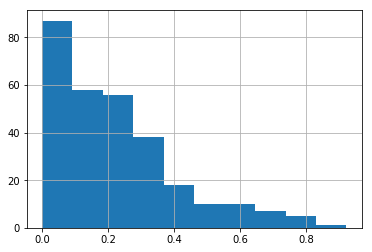

In [51]:
df.isnull().mean(axis=1).hist()

In [52]:
df = df[df.isnull().mean(axis=1) < 0.4]

In [53]:
df.shape

(250, 38)

In [54]:
df.isnull().mean(axis=0).sort_values()

Viton                           0.004
stainless steel - 316           0.008
Fluorocarbon (FKM)              0.008
PTFE                            0.012
EPDM                            0.016
stainless steel - 304           0.020
Buna N (Nitrile)                0.024
Aluminum                        0.032
Neoprene                        0.032
PVC                             0.040
Kalrez                          0.048
Polypropylene                   0.052
Natural rubber                  0.072
Nylon                           0.088
PVDF (Kynar)                    0.092
Carbon Steel                    0.096
Polyurethane                    0.100
ChemRaz (FFKM)                  0.112
LDPE                            0.116
Epoxy                           0.116
Carbon graphite                 0.116
Hastelloy-C                     0.128
CPVC                            0.128
Bronze                          0.128
Acetal (Delrin)                 0.136
Hypalon                         0.180
Silicone    

In [55]:
# filter materials with limited information
df = df[df.columns[df.isnull().mean(axis=0) < 0.3]]

In [56]:
df.shape

(250, 32)

#### Vectorize!

In [57]:
#vecs = {'A': np.array([1,0,0,0,0]), 'B': (0,1,0,0,0), 'C': (0,0,1,0,0), 'D':(0,0,0,1,0), np.NaN: (0,0,0,0,1)} ##fail
labs = {'A': 0, 'B': 1, 'C': 2, 'D': 3, np.NaN: 4}

In [58]:
ser = df['Hypalon'].replace(labs)
ser.head()

chemical
acetaldehyde            2
acetamide               1
acetic acid             2
acetic acid, glacial    2
acetic anhydride        0
Name: Hypalon, dtype: int64

In [59]:
lb = preprocessing.LabelBinarizer()
lb.fit(ser)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [60]:
lb.classes_

array([0, 1, 2, 3, 4])

In [61]:
lb.transform(ser)

array([[0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       ..., 
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [62]:
df['Hypalon'].head()

chemical
acetaldehyde            C
acetamide               B
acetic acid             C
acetic acid, glacial    C
acetic anhydride        A
Name: Hypalon, dtype: object

In [63]:
cols = [lb.transform(col.replace(labs)) for name, col in df.iteritems()]

In [64]:
cols[0:2]

[array([[0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        ..., 
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]]), array([[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        ..., 
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0]])]

In [65]:
np.stack(cols, axis=1).shape

(250, 32, 5)

In [66]:
ary = np.concatenate(cols, axis=1)
ary = ary.astype(float)
ary.shape

(250, 160)

In [67]:
ts = TSNE(2, perplexity=30, n_iter=2000)
x_em = ts.fit_transform(ary)

In [68]:
def tsne_plot(embedAry, labels=None):
    scatter(embedAry[:,0], embedAry[:,1], c=labels)

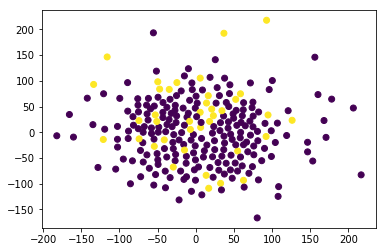

In [69]:
tsne_plot(x_em, labels=df.index.str.contains('acid'))

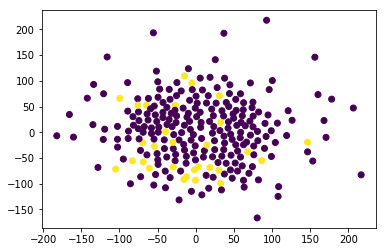

In [70]:
tsne_plot(x_em, labels=df.index.str.contains('ol'))

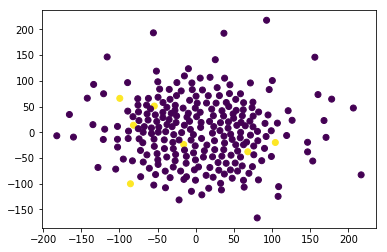

In [71]:
tsne_plot(x_em, labels=df.index.str.contains('butyl'))

I reckon since the compat chart contains a combination of alkane/fatty alcohols/acids, along with the hydrophilic ones, the spread of that group is large

In [72]:
def vdist(vec, ary):
    return np.sum((ary-vec)**2, axis=1)**0.5

In [73]:
v_ethanol = ary[df.index.str.contains('ethyl alcohol')][0]
ary.shape, v_ethanol.shape

((250, 160), (160,))

In [74]:
(ary**2 - v_ethanol**2).shape

(250, 160)

In [75]:
#vdist(v_ethanol, ary)

In [76]:
ethanolDist = pd.Series(vdist(v_ethanol, ary), index=df.index)
ethanolDist.sort_values()

chemical
ethyl alcohol             0.000000
ethanol                   1.414214
butyl alcohol             3.741657
glycerin                  4.472136
isobutyl alcohol          4.472136
amyl alcohol              4.472136
sodium carbonate          4.472136
diethylamine              4.690416
diethylene glycol         4.690416
amyl alcohol              4.690416
propyl alcohol            4.898979
sodium cyanide            5.099020
glucose                   5.099020
potassium iodide          5.099020
molasses                  5.099020
butane                    5.099020
ammonium nitrate          5.099020
calcium carbonate         5.099020
sodium bicarbonate        5.099020
calcium chloride          5.099020
calcium nitrate           5.099020
acetone                   5.291503
ferric sulfate            5.291503
barium chloride           5.291503
potassium permanganate    5.291503
potassium sulfate         5.291503
propylene glycol          5.291503
salicylic acid            5.291503
potassium c

In [77]:
ethanolDist['methyl alcohol']

5.6568542494923806

## proof of concept: not bad
though there is probably a lot of noise due to the sheer number of blanks. they definitely goof with the distance

In [78]:
df.isnull().mean().mean()

0.104625

In [79]:
ary[:,:].shape

(250, 160)

In [80]:
df.iloc[50:55]

,Hypalon,PVC,LDPE,Kalrez,Viton,Kel-F,CPVC,Fluorocarbon (FKM),Copper,PTFE,...,Natural rubber,Carbon graphite,Acetal (Delrin),EPDM,stainless steel - 316,Bronze,Silicone,Polyurethane,Neoprene,Polypropylene
chemical,,,,,,,,,,,,,,,,,,,,,
benzoic acid,D,A,A,A,A,A,A,A,NaN,A,...,D,A,B,D,B,B,B,D,B,B
benzol,D,NaN,C,A,A,A,NaN,B,B,A,...,D,A,A,D,A,A,D,D,D,B
benzyl chloride,D,NaN,NaN,A,A,NaN,NaN,A,D,NaN,...,D,A,A,D,B,D,D,D,D,C
boric acid,A,A,A,A,A,A,A,A,B,A,...,A,A,A,A,A,B,A,A,D,A
bromine,D,C,D,A,A,A,D,A,NaN,A,...,D,D,D,D,D,D,D,D,D,D


In [81]:
# mask off the nans
ary[52][4::5]

array([ 0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.])

In [82]:
ary.reshape(-1, 32, 5)[52]

array([[ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  

In [83]:
ary2 = ary.reshape(-1, 32, 5)
print(ary2.shape)
ary2 = ary2[:, :, :4]
print(ary2.shape)
ary2 = ary2.reshape(-1, 32*4)
ary2.shape

(250, 32, 5)
(250, 32, 4)


(250, 128)

In [84]:
ts = TSNE(2, perplexity=30, n_iter=2000)
x_em = ts.fit_transform(ary2)

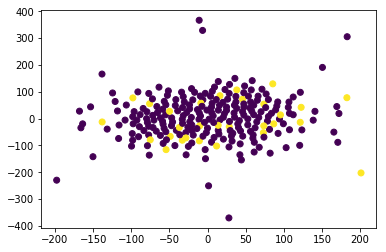

In [85]:
tsne_plot(x_em, labels=df.index.str.contains('ol'))

In [86]:
v_ethanol = ary2[df.index.str.contains('ethyl alcohol')][0]

ethanolDist = pd.Series(vdist(v_ethanol, ary2), index=df.index)
ethanolDist.sort_values()

chemical
ethyl alcohol             0.000000
ethanol                   1.414214
butyl alcohol             3.464102
isobutyl alcohol          4.123106
diethylene glycol         4.242641
sodium carbonate          4.358899
glycerin                  4.358899
amyl alcohol              4.358899
potassium iodide          4.358899
diethylamine              4.582576
molasses                  4.582576
calcium carbonate         4.582576
amyl alcohol              4.582576
propyl alcohol            4.690416
salicylic acid            4.690416
starch                    4.690416
glucose                   4.795832
calcium chloride          4.795832
butane                    4.898979
sodium cyanide            4.898979
potassium permanganate    4.898979
manganese sulfate         4.898979
calcium nitrate           4.898979
sodium bicarbonate        5.000000
propylene glycol          5.000000
phthalic acid             5.000000
silicone                  5.000000
sodium metasilicate       5.000000
barium cyan

### bummer. 
## oh wait
#### it's not really a valid comparison
since the set of chemicals with nans in a given category complements the filled values, dropping the nan label column is only trivially effective. 

yeay data category balancing...
what we need here is a fuzzy embedding based on material compatibility. Sounds like a job for neural networks, or perhaps markov chains.


In [87]:
df[df.index.str.contains('ol')]

,Hypalon,PVC,LDPE,Kalrez,Viton,Kel-F,CPVC,Fluorocarbon (FKM),Copper,PTFE,...,Natural rubber,Carbon graphite,Acetal (Delrin),EPDM,stainless steel - 316,Bronze,Silicone,Polyurethane,Neoprene,Polypropylene
chemical,,,,,,,,,,,,,,,,,,,,,
amyl alcohol,A,A,B,A,A,A,A,A,A,A,...,B,A,A,A,A,A,D,D,A,B
benzyl alcohol,C,D,D,NaN,A,A,A,A,B,A,...,D,NaN,A,B,B,A,NaN,D,C,A
butyl alcohol,A,A,A,A,A,NaN,A,A,A,A,...,A,A,A,A,A,A,B,D,A,A
diacetone alcohol,D,B,B,A,D,B,NaN,D,NaN,A,...,D,A,A,A,A,A,D,D,D,B
ethyl alcohol,A,C,B,A,A,A,B,A,A,A,...,A,A,A,A,A,A,B,D,A,A
hexyl alcohol,B,A,A,A,C,NaN,NaN,B,NaN,A,...,A,NaN,A,C,A,A,B,D,A,NaN
isobutyl alcohol,A,A,A,A,A,NaN,NaN,A,NaN,A,...,A,A,A,A,A,A,A,D,A,A
isopropyl alcohol,A,A,A,A,A,NaN,C,A,B,A,...,A,A,A,A,B,A,A,D,B,A
methyl alcohol,A,A,A,A,C,A,A,C,B,A,...,A,A,A,A,A,A,A,D,A,A


In [88]:
ary.shape

(250, 160)

In [89]:
ary_mat = ary.reshape(-1, 32, 5)
ary_mat = ary_mat.swapaxes(0, 1)
ary_mat = ary_mat.reshape(32, -1)
ary_mat.shape

(32, 1250)

In [90]:
ts = TSNE(2, perplexity=30, n_iter=2000)
y_em = ts.fit_transform(ary_mat.T)

In [91]:
y_em.shape

(1250, 2)

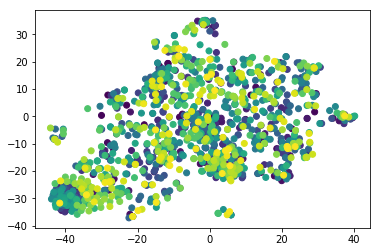

In [92]:
tsne_plot(y_em, labels=np.arange(len(y_em)))

that's totally not what I meant to do, but it's cool, and has some signs of clusters, so I am leaving it for now

In [93]:
ts = TSNE(2, perplexity=30, n_iter=2000)
y_em = ts.fit_transform(ary_mat)
y_em.shape

(32, 2)

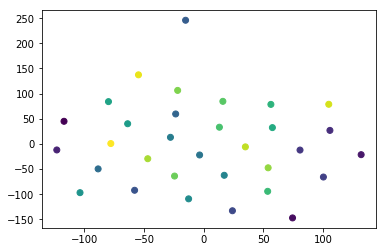

In [94]:
tsne_plot(y_em, labels=np.arange(len(y_em)))

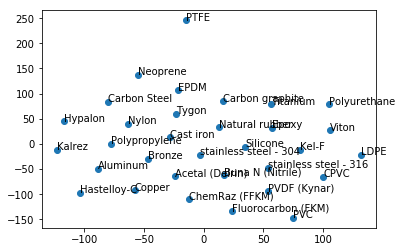

In [95]:
fig, ax = plt.subplots()
ax.scatter(y_em[:,0], y_em[:,1])

for i, txt in enumerate(df.columns):
    ax.annotate(txt, (y_em[i,0], y_em[i,1]))
#     print(i, txt)
rcParams['figure.figsize'] = 15,7


In [96]:
pca = PCA(2)
y_em = pca.fit_transform(ary_mat)
y_em = preprocessing.normalize(y_em, axis=0)

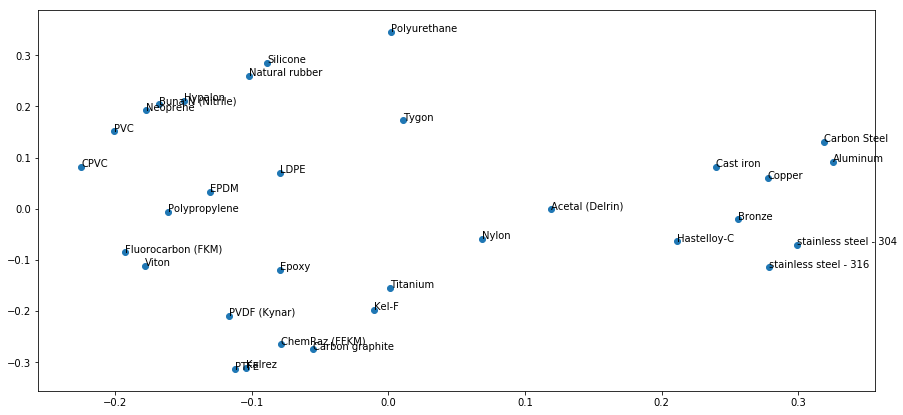

In [97]:
fig, ax = plt.subplots()
ax.scatter(y_em[:,0], y_em[:,1])

for i, txt in enumerate(df.columns):
    ax.annotate(txt, (y_em[i,0], y_em[i,1]))
#     print(i, txt)
rcParams['figure.figsize'] = 15,7

hey, not too shabby!

what if we map (exc, good, n/a, fair, poor) to (1, .5, 0, -.5, -1) and use that to weight the material eigenvector, then accumulate? that should give an embedding in ndim (same dim as mat eigenvec) where N/A's have no weight. 


In [98]:
y_em.shape

(32, 2)

In [99]:
n = 3
print(df.columns[n])
print(y_em[n])

Kalrez
[-0.10445403 -0.31082773]


In [100]:
subval = 0.5
valmap = {'A':1, 'B': subval, np.nan:0, 'C': -subval, 'D': -1 }
vec = df.iloc[0].replace(valmap)
vec.shape

(32,)

In [101]:
assert vec.shape[0] == y_em.shape[0]

In [102]:
accu = 0.0
for i, eig in enumerate(y_em):
    accu += eig * vec[i]
accu

array([ 1.61440018, -2.1677637 ])

In [103]:
vec.as_matrix().reshape(1, -1) @ y_em

array([[ 1.61440018, -2.1677637 ]])

In [104]:
newary = df.replace(valmap).as_matrix()
newary.shape

(250, 32)

In [105]:
newembed = newary @ y_em
newembed.shape

(250, 2)

In [106]:
def scatter_label(xy, labels, color=None):
    ax = plt.axes()
    ax.scatter(xy[:,0], xy[:,1])

    for i, txt in enumerate(labels):
        ax.annotate(txt, (xy[i,0], xy[i,1]), color=color)

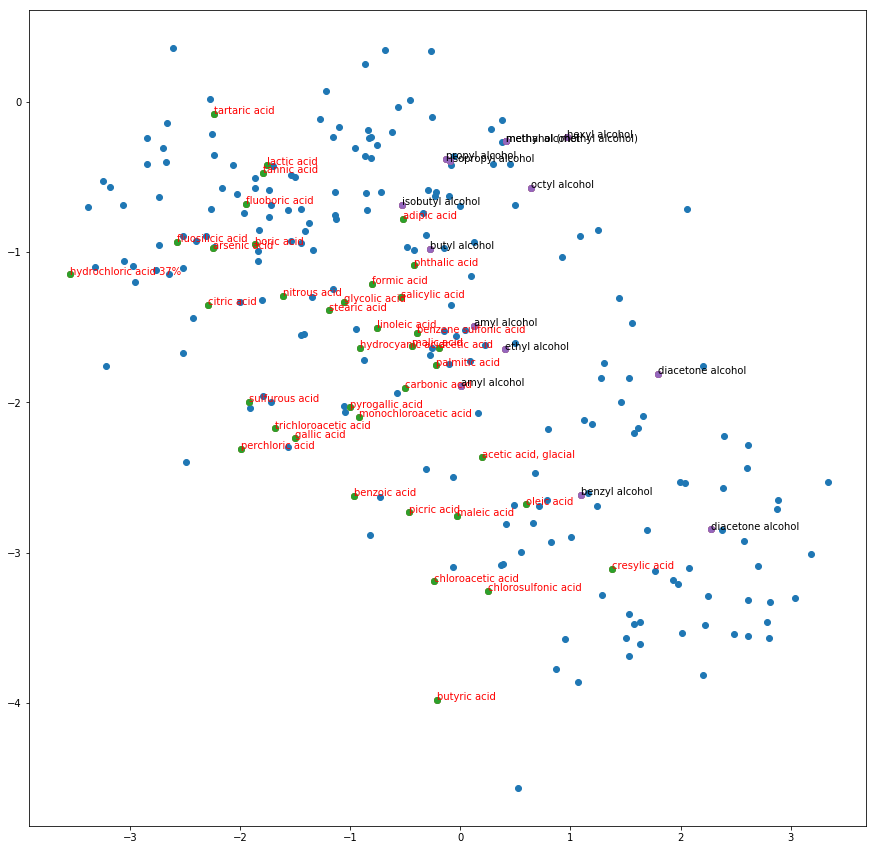

In [107]:
rcParams['figure.figsize'] = 15,15
# tsne_plot(newembed, labels=df.index.str.contains('ol'))
tsne_plot(newembed)
mask = labels=df.index.str.contains('acid')
tsne_plot(newembed[mask] )
scatter_label(newembed[mask], df.index[mask], color='red')
mask = labels=df.index.str.contains('alcohol')
tsne_plot(newembed[mask] )
scatter_label(newembed[mask], df.index[mask], color='k')

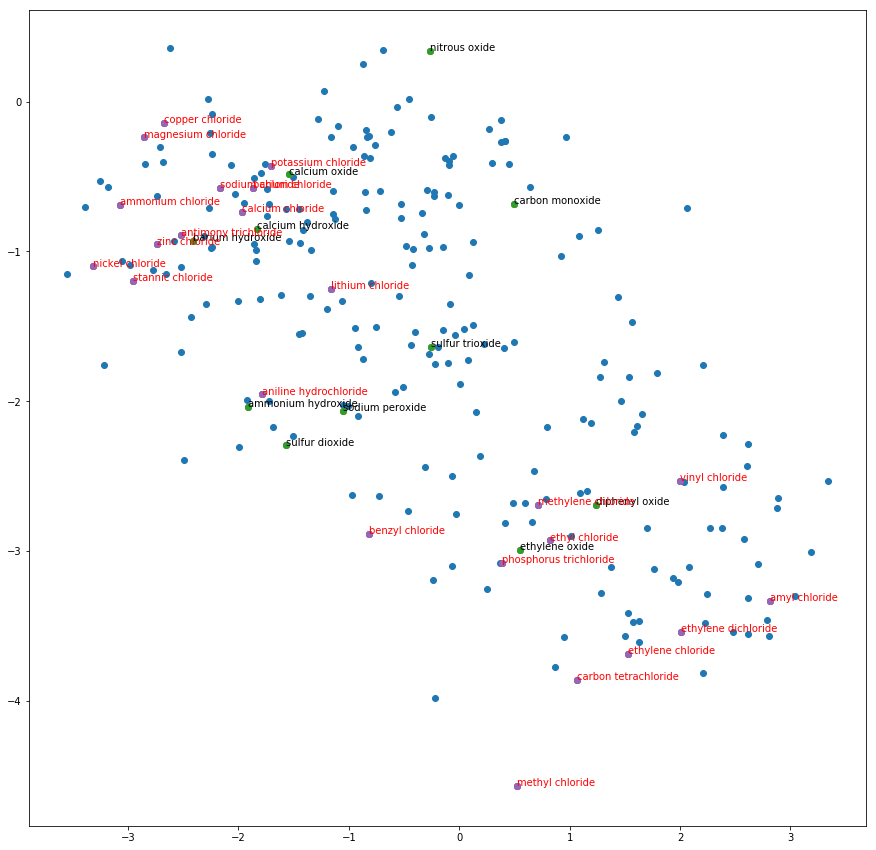

In [115]:
rcParams['figure.figsize'] = 15,15
# tsne_plot(newembed, labels=df.index.str.contains('ol'))
tsne_plot(newembed)
mask = labels=df.index.str.contains('oxide')
tsne_plot(newembed[mask] )
scatter_label(newembed[mask], df.index[mask], color='k')
mask = labels=df.index.str.contains('chloride')
tsne_plot(newembed[mask] )
scatter_label(newembed[mask], df.index[mask], color='red')